In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
import os

from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
train_data = "hida_workspace/trainSet/trainSet.txt"
test_data = "hida_workspace/testSet/testSet.txt"

df_train = pd.read_csv(train_data)
df_test = pd.read_csv(test_data)

In [3]:
# Merge the two datasets
train_test = [df_train, df_test]
df_train_test = pd.concat(train_test)
df_train_test['Prognosis'][df_train_test['Prognosis'] == '<undefined>'] = np.nan

/software/all/jupyter/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [4]:
df_train_test

,PatientID,ImageFile,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,Fibrinogen,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure,Prognosis
0,P_131,P_131.png,D,35.913889,0.0,39.3,1.0,0.0,5.76,43.40,651.0,387.0,157.0,94.0,NaN,NaN,NaN,0.0,NaN,MILD
1,P_132,P_132.png,D,57.266667,0.0,37.0,0.0,0.0,11.48,64.00,700.0,338.0,601.0,94.0,75.0,96.9,7.42,0.0,NaN,MILD
2,P_195,P_195.png,D,79.263889,0.0,37.8,1.0,0.0,6.21,115.30,698.0,356.0,448.0,94.0,63.0,94.6,7.39,1.0,NaN,SEVERE
3,P_193,P_193.png,D,82.000000,0.0,38.0,1.0,0.0,7.28,149.30,513.0,482.0,NaN,97.0,68.0,96.3,7.46,0.0,NaN,SEVERE
4,P_140,P_140.png,D,60.791667,1.0,37.0,1.0,0.0,6.37,20.70,NaN,NaN,210.0,93.0,NaN,97.3,NaN,0.0,NaN,MILD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,P_88,NaN,A,58.000000,0.0,36.7,1.0,0.0,5.14,NaN,NaN,NaN,NaN,NaN,89.0,99.0,7.56,1.0,0.0,NaN
116,P_92,P_92.png,A,48.000000,0.0,37.4,NaN,NaN,5.17,2.60,NaN,178.0,NaN,88.0,83.0,NaN,7.42,1.0,NaN,NaN
117,P_86,P_86.png,A,87.000000,0.0,37.5,NaN,NaN,8.10,20.76,NaN,NaN,NaN,89.0,60.0,93.0,7.43,1.0,0.0,NaN
118,P_9,P_9.png,A,70.000000,1.0,38.0,0.0,1.0,3.61,9.52,NaN,NaN,552.0,NaN,41.0,77.0,7.44,1.0,NaN,NaN


In [5]:
# all variables in the dataset (incl. outcome)
variables = list(df_train_test.columns)
# which variables to use for catboost (only numerical ones!)
variables_for_catboost = variables[3:20]
print(variables_for_catboost)

['Age', 'Sex', 'Temp_C', 'Cough', 'DifficultyInBreathing', 'WBC', 'CRP', 'Fibrinogen', 'LDH', 'Ddimer', 'Ox_percentage', 'PaO2', 'SaO2', 'pH', 'CardiovascularDisease', 'RespiratoryFailure', 'Prognosis']


In [6]:
# Set up catboost for each variable separately
# Here we don't update and always use the original dataset with missing values in all variables

# Generate new dataframe for imputed values (for this we copy the original test_trai datetset and store the index of the imputed ones and fill them in)
df_imputed_train_test = df_train_test.copy()
del df_imputed_train_test['Prognosis']

# Prognosis should be Boolian
df_imputed_train_test['Prognosis']= np.nan
df_imputed_train_test['Prognosis'][df_train_test['Prognosis']=='MILD'] = 0
df_imputed_train_test['Prognosis'][df_train_test['Prognosis']=='SEVERE'] = 1

df_train_test['Prognosis'] = df_imputed_train_test['Prognosis']

/software/all/jupyter/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/software/all/jupyter/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [7]:
df_imputed_train_test

,PatientID,ImageFile,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,Fibrinogen,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure,Prognosis
0,P_131,P_131.png,D,35.913889,0.0,39.3,1.0,0.0,5.76,43.40,651.0,387.0,157.0,94.0,NaN,NaN,NaN,0.0,NaN,0.0
1,P_132,P_132.png,D,57.266667,0.0,37.0,0.0,0.0,11.48,64.00,700.0,338.0,601.0,94.0,75.0,96.9,7.42,0.0,NaN,0.0
2,P_195,P_195.png,D,79.263889,0.0,37.8,1.0,0.0,6.21,115.30,698.0,356.0,448.0,94.0,63.0,94.6,7.39,1.0,NaN,1.0
3,P_193,P_193.png,D,82.000000,0.0,38.0,1.0,0.0,7.28,149.30,513.0,482.0,NaN,97.0,68.0,96.3,7.46,0.0,NaN,1.0
4,P_140,P_140.png,D,60.791667,1.0,37.0,1.0,0.0,6.37,20.70,NaN,NaN,210.0,93.0,NaN,97.3,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,P_88,NaN,A,58.000000,0.0,36.7,1.0,0.0,5.14,NaN,NaN,NaN,NaN,NaN,89.0,99.0,7.56,1.0,0.0,NaN
116,P_92,P_92.png,A,48.000000,0.0,37.4,NaN,NaN,5.17,2.60,NaN,178.0,NaN,88.0,83.0,NaN,7.42,1.0,NaN,NaN
117,P_86,P_86.png,A,87.000000,0.0,37.5,NaN,NaN,8.10,20.76,NaN,NaN,NaN,89.0,60.0,93.0,7.43,1.0,0.0,NaN
118,P_9,P_9.png,A,70.000000,1.0,38.0,0.0,1.0,3.61,9.52,NaN,NaN,552.0,NaN,41.0,77.0,7.44,1.0,NaN,NaN


In [8]:
# Set up catboost for each variable separately
# Here we don't update and always use the original dataset with missing values in all variables

# Generate new dataframe for imputed values (for this we copy the original test_trai datetset and store the index of the imputed ones and fill them in)
#df_imputed_train_test = df_train_test.copy()
#del df_imputed_train_test['Prognosis']

# Prognosis should be Boolian
#df_imputed_train_test['Prognosis']=0
#df_imputed_train_test['Prognosis'][df_train_test['Prognosis']=='MILD'] = 0
#df_imputed_train_test['Prognosis'][df_train_test['Prognosis']=='SEVERE'] = 1

for catboost_variable in variables_for_catboost:
    #catboost_variable = variables_for_catboost[i]
    catboost_features = variables_for_catboost.copy()
    catboost_features.remove(catboost_variable)
    catboost_df_train_test = df_train_test[df_train_test[catboost_variable].notna()]
    X_train = catboost_df_train_test[catboost_features]
    y_train = catboost_df_train_test[catboost_variable]
    
    index_missing = df_train_test[catboost_variable].isna()
    catboost_df_test = df_train_test[df_train_test[catboost_variable].isna()]
    X_test = catboost_df_test[catboost_features]
    y_test = catboost_df_test[catboost_variable]

    # fit the model 
    model = CatBoostClassifier(verbose=0, n_estimators=15)
    model.fit(X_train, y_train)

    # make a prediction
    yhat = model.predict(X_test)
    df_imputed_train_test[catboost_variable][df_train_test[catboost_variable].isna()] = list(yhat)

/software/all/jupyter/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


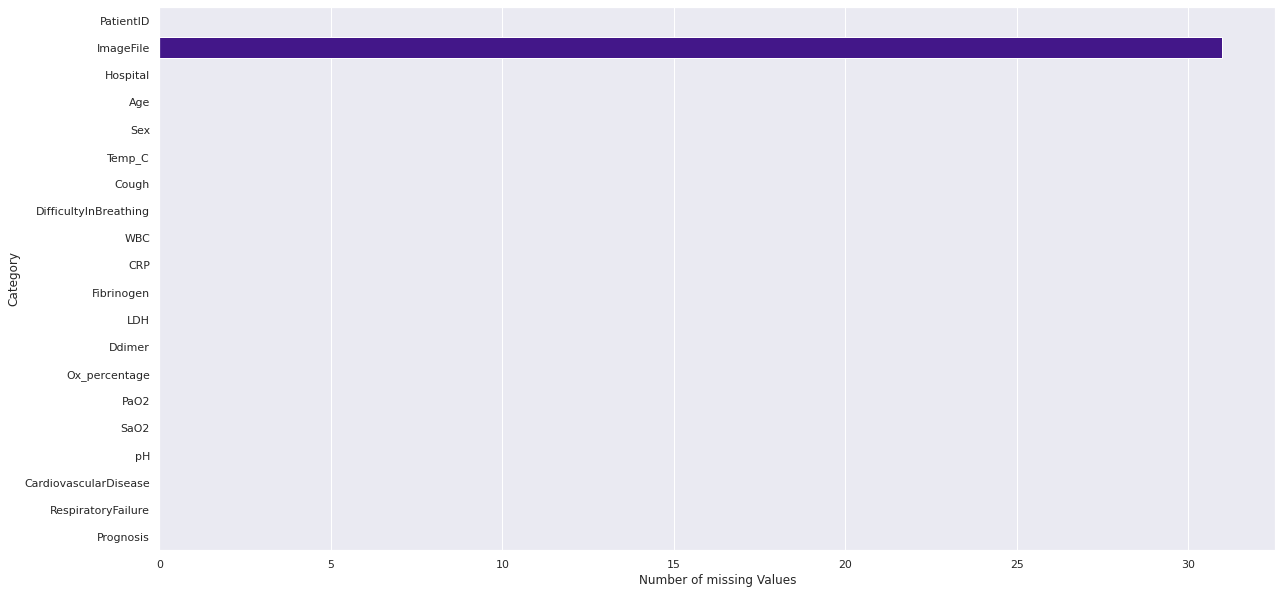

In [9]:
# get an overview about amount of missing data:
na_stats = []
for col in df_imputed_train_test.columns:
    na_stats.append((col, df_imputed_train_test[col].isna().sum()))
na_df_imputed_train_test = pd.DataFrame(na_stats)

# histplot of missing data:
fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(x=1, y=0, data=na_df_imputed_train_test, palette="plasma", ax=ax)
ax.set_xlabel("Number of missing Values")
ax.set_ylabel("Category")
plt.show()

In [14]:
df_imputed_train_test.to_csv('Results/imputation_raw_training_test.txt', header=None, index=None, sep=',', mode='a')

In [15]:
df_imputed_train_test

,PatientID,ImageFile,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,Fibrinogen,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure,Prognosis
0,P_131,P_131.png,D,35.913889,0.0,39.3,1.0,0.0,5.76,43.40,651.0,387.0,157.0,94.0,61.0,94.0,7.45,0.0,0.0,0.0
1,P_132,P_132.png,D,57.266667,0.0,37.0,0.0,0.0,11.48,64.00,700.0,338.0,601.0,94.0,75.0,96.9,7.42,0.0,0.0,0.0
2,P_195,P_195.png,D,79.263889,0.0,37.8,1.0,0.0,6.21,115.30,698.0,356.0,448.0,94.0,63.0,94.6,7.39,1.0,0.0,1.0
3,P_193,P_193.png,D,82.000000,0.0,38.0,1.0,0.0,7.28,149.30,513.0,482.0,3583.0,97.0,68.0,96.3,7.46,0.0,0.0,1.0
4,P_140,P_140.png,D,60.791667,1.0,37.0,1.0,0.0,6.37,20.70,700.0,250.0,210.0,93.0,72.0,97.3,7.49,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,P_88,NaN,A,58.000000,0.0,36.7,1.0,0.0,5.14,6.45,550.0,324.0,140.0,100.0,89.0,99.0,7.56,1.0,0.0,0.0
116,P_92,P_92.png,A,48.000000,0.0,37.4,1.0,0.0,5.17,2.60,700.0,178.0,140.0,88.0,83.0,98.0,7.42,1.0,0.0,0.0
117,P_86,P_86.png,A,87.000000,0.0,37.5,1.0,1.0,8.10,20.76,517.0,324.0,2784.0,89.0,60.0,93.0,7.43,1.0,0.0,1.0
118,P_9,P_9.png,A,70.000000,1.0,38.0,0.0,1.0,3.61,9.52,700.0,281.0,552.0,97.0,41.0,77.0,7.44,1.0,0.0,0.0


In [16]:
# separate the two datasets:
df_imputed_train = df_imputed_train_test.iloc[0:862, : ]
df_imputed_test = df_imputed_train_test.iloc[863:983, ]

In [17]:
df_imputed_train.to_csv('Results/imputation_raw_training.txt', header=None, index=None, sep=',', mode='a')
df_imputed_test.to_csv('Results/imputation_raw_test.txt', header=None, index=None, sep=',', mode='a')